In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import pandas as pd
from Preprocessing.preprocessing import preprocessing
from Models.LSTM.lightningLSTM import LightningLSTM
from Preprocessing.dataclasses import StockPriceDataModule
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar, StochasticWeightAveraging
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, Trials
import time
import pickle
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [18]:
df = pd.read_csv('Data\Stock\StockBars\MSFT_Minute')

# Check if there is a saved Trials object and load it if it exists
if os.path.isfile('trials.pkl'):
    with open('trials.pkl', 'rb') as f:
        trials = pickle.load(f)
else:
    trials = Trials()

def objective(params):

    # Set the hyperparameters, batch size, and sequence length
    LEARNING_RATE = params['learning_rate']
    BATCH_SIZE = params['batch_size']
    SEQUENCE_LENGTH = params['sequence_length']
    HIDDEN_SIZE = params['hidden_size']
    NUM_LAYERS = params['num_layers']
    
    data_train, data_test, _ = preprocessing(df=df, lag=1, sequence_length=SEQUENCE_LENGTH, dif_all=True, train_size=0.99)

    # Create the data module with the given batch size and sequence length
    data_module = StockPriceDataModule(train_sequence=data_train, test_sequence=data_test, batch_size=BATCH_SIZE, num_workers=4)
    data_module.setup()

    # Create the Lightning module with the given hyperparameters
    model = LightningLSTM(input_size=9, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, learning_rate=LEARNING_RATE)

    # Train the model for a fixed number of epochs and measure the training time
    start_time = time.time()
    
    trainer = pl.Trainer(max_epochs=5, callbacks=[TQDMProgressBar(refresh_rate=100)], accelerator="gpu", devices=1, limit_val_batches=0)
    trainer.fit(model, data_module)

    training_time = time.time() - start_time

    # Evaluate the model on the test set and return the loss
    test_loss = trainer.test(model, data_module)[0]['test_loss']
    
    # Log the performance for the current hyperparameter configuration
    log_dict = {
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE,
        'sequence_length': SEQUENCE_LENGTH,
        'hidden_size': HIDDEN_SIZE,
        'num_layers': NUM_LAYERS,
        'test_loss': test_loss,
        'training_time': training_time
    }

    # Save the results to a text file
    result_file = 'results.txt'
    if os.path.exists(result_file) and os.path.getsize(result_file) > 0:
        with open(result_file, 'a') as f:
            # Write the results for the current hyperparameter configuration to the file
            f.write(','.join([str(log_dict[col]) for col in log_dict.keys()]) + '\n')
    else:
        with open(result_file, 'a') as f:
            # Write the column names to the file
            f.write(','.join(log_dict.keys()) + '\n')
            # Write the results for the current hyperparameter configuration to the file
            f.write(','.join([str(log_dict[col]) for col in log_dict.keys()]) + '\n')

    # Return the test loss
    return test_loss

space = {
    'learning_rate': hp.loguniform('learning_rate', -6, -1),
    'batch_size': hp.choice('batch_size', [16, 32, 64, 128]),
    'sequence_length': hp.choice('sequence_length', [32, 64, 128, 256]),  
    'hidden_size': hp.choice('hidden_size', [64, 80, 96, 112, 128, 256, 512]),
    'num_layers': hp.choice('num_layers', [1, 2, 3])
}

# Set the maximum number of evaluations for the hyperparameter search
max_evals = 15

# Resume the search if there are saved trials
if len(trials.trials) > 0:
    print(f"Resuming search with {len(trials.trials)} trials")
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
else:
    print("Starting new search")
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=max_evals, trials=trials)

# Save the trials object to a file
with open('trials.pkl', 'wb') as f:
    pickle.dump(trials, f)

Resuming search with 14 trials
 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | model     | LSTM    | 203 K 
1 | criterion | MSELoss | 0     
--------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.814     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.9169902801513672     │
└───────────────────────────┴───────────────────────────┘

100%|██████████| 15/15 [06:11<00:00, 371.58s/trial, best loss: 1.715910792350769]


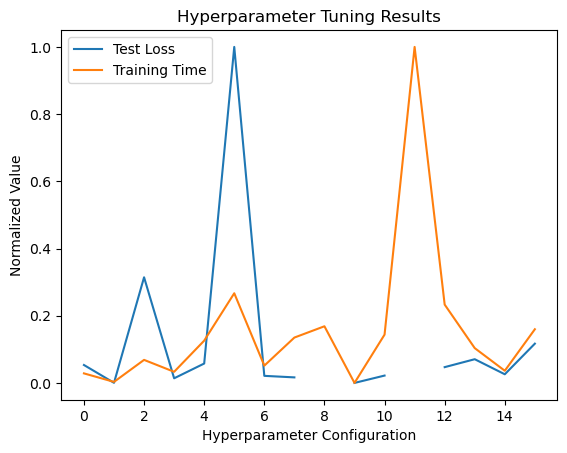

In [21]:
# Read in the text file
df = pd.read_csv('results.txt', delimiter=',')

# Normalize the test_loss and training_time columns using Min-Max scaling
scaler = MinMaxScaler()
df['test_loss_scaled'] = scaler.fit_transform(df[['test_loss']])
df['training_time_scaled'] = scaler.fit_transform(df[['training_time']])

# Plot the two normalized columns on the same graph
plt.plot(df['test_loss_scaled'], label='Test Loss')
plt.plot(df['training_time_scaled'], label='Training Time')
plt.legend()
plt.title('Hyperparameter Tuning Results')
plt.xlabel('Hyperparameter Configuration')
plt.ylabel('Normalized Value')
plt.show()

df = df.dropna(subset=['test_loss', 'training_time'])

In [26]:
top_test_loss = df.sort_values(by='test_loss', ascending=True).head(3)
top_training_time = df.sort_values(by='training_time', ascending=True).head(3)

In [27]:
print("Top 3 in terms of test loss:")
top_test_loss

Top 3 in terms of test loss:


,learning_rate,batch_size,sequence_length,hidden_size,num_layers,test_loss,training_time,test_loss_scaled,training_time_scaled
9,0.024194,128,32,64,2,1.715911,71.611034,0.000000,0.000000
1,0.007676,128,32,80,1,1.716446,77.027931,0.000311,0.003097
3,0.089707,64,32,128,2,1.739614,129.528876,0.013776,0.033110


In [28]:
print("Top 3 in terms of training time:")
top_training_time

Top 3 in terms of training time:


,learning_rate,batch_size,sequence_length,hidden_size,num_layers,test_loss,training_time,test_loss_scaled,training_time_scaled
9,0.024194,128,32,64,2,1.715911,71.611034,0.000000,0.000000
1,0.007676,128,32,80,1,1.716446,77.027931,0.000311,0.003097
0,0.007162,64,128,128,2,1.807687,121.276107,0.053339,0.028392
